In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
import pickle
import pandas
from sklearn.metrics import mean_squared_error

# Andiamo a costruire il modello LSTM

In [3]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


(150, 1)


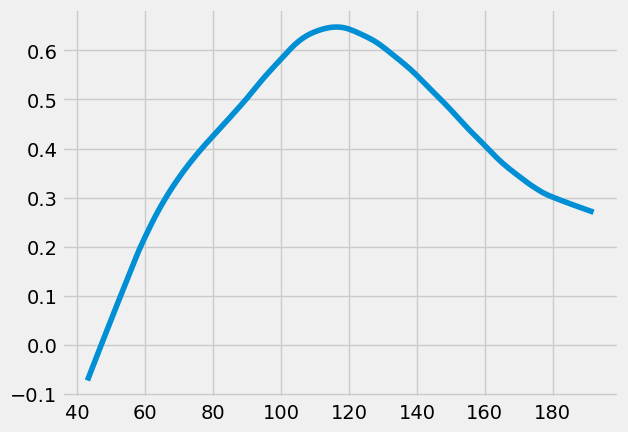

In [4]:
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
print()
NDVI[30].plot()

dataset = np.reshape(NDVI[30].data_matrix.flatten(),(NDVI[30].data_matrix.flatten().shape[0],1))
#pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

print(dataset.shape)

In [5]:
# Checking for missing values dataset[:'2016'].iloc[:,1:2].values
trainingLenght = 120
testLenght = 30

training_set = dataset[:trainingLenght]
print(training_set.shape)
print(len(training_set))
test_set = dataset[trainingLenght:]
print(test_set.shape)
print(len(test_set))

(120, 1)
120
(30, 1)
30


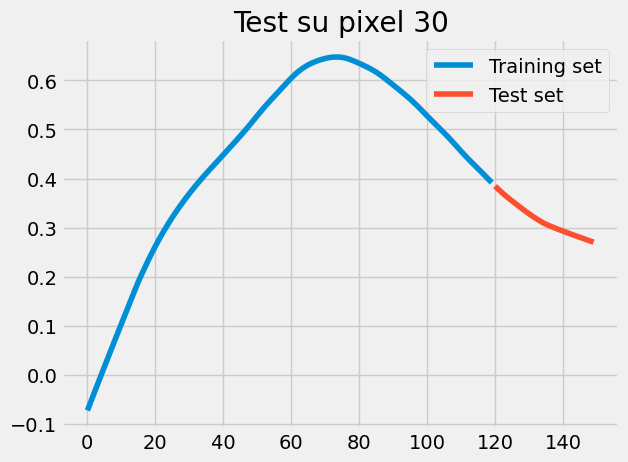

In [6]:
s = pd.Series(dataset.flatten())
s[:trainingLenght].plot(legend=True)
s[trainingLenght:].plot(legend=True)
plt.legend(['Training set','Test set'])
plt.title('Test su pixel 30')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [98]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
Window = 10
X_train = []
y_train = []
for i in range(Window,trainingLenght):
    X_train.append(training_set_scaled[i-Window:i,0])
    y_train.append(training_set_scaled[i,0])
    '''print(training_set_scaled[i-60:i,0])
    print(training_set_scaled[i,0])'''
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train[2])

[0.0497174  0.07444644 0.09908683 0.12363859 0.14810157 0.17247447
 0.19675603 0.22095236 0.24507219 0.26912569]


In [99]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
print(y_train.shape)

(110, 10, 1)
(110,)


In [100]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

In [101]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
4/4 [==============================] - 7s 15ms/step - loss: 0.3887
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0219
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0234
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0120
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0129
Epoch 7/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0356
Epoch 8/50
4/4 [==============================] - 0s 18ms/step - loss: 0.0120
Epoch 9/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0200
Epoch 10/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0202
Epoch 11/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0135
Epoch 12/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0165
Epoch 13/50
4/4 [==============================] - 0s 15ms/st

In [93]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((s[:trainingLenght],s[trainingLenght:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set)-Window:].values # Da qui ho tolto - 10
inputs = dataset_total[len(dataset_total)-len(test_set)-Window:].values # Da qui ho tolto - 10
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [102]:
# Preparing X_test and predicting the prices

X_test = []
#X_test = dataset_total[len(dataset_total)-2*Window:-Window]
for i in range(Window,testLenght+Window):
    X_test.append(inputs[i-Window:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (1,Window,1))
print(X_test.shape)
predicted_stock_price = regressor.predict(X_test)

predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price)

(1, 10, 1)
1/1 [==============================] - 1s 1s/step
[[0.20165668]]


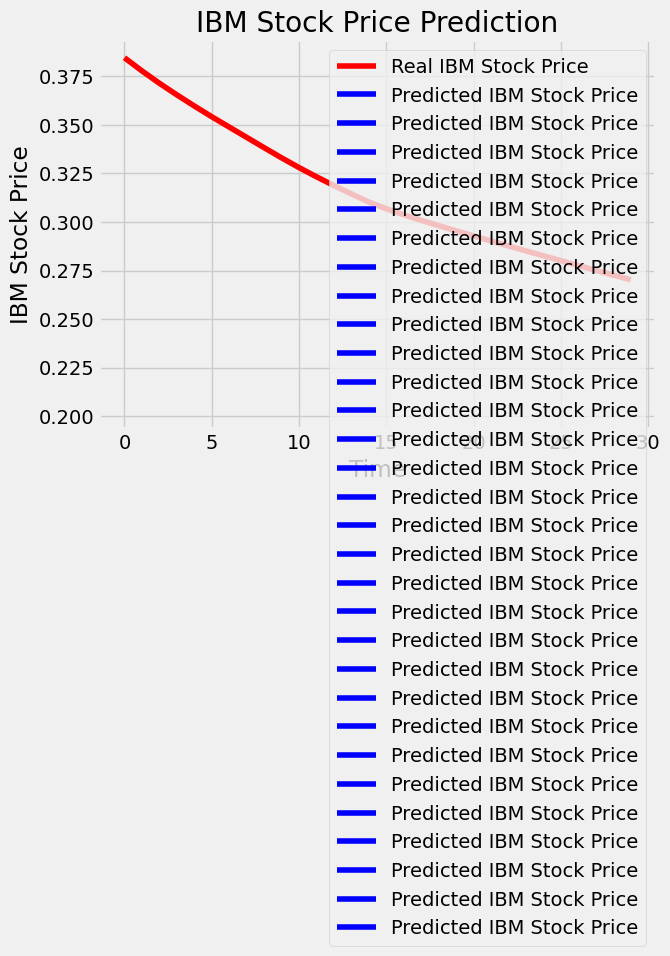

In [53]:
# Visualizing the results for LSTM
#plot_predictions(test_set,predicted_stock_price)


Epoch 1/1000
2/2 [==============================] - 7s 68ms/step - loss: 0.2497
Epoch 2/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.2278
Epoch 3/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.1995
Epoch 4/1000
2/2 [==============================] - 0s 66ms/step - loss: 0.1579
Epoch 5/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.1244
Epoch 6/1000
2/2 [==============================] - 0s 65ms/step - loss: 0.0967
Epoch 7/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.0820
Epoch 8/1000
2/2 [==============================] - 0s 67ms/step - loss: 0.0669
Epoch 9/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.0566
Epoch 10/1000
2/2 [==============================] - 0s 67ms/step - loss: 0.0499
Epoch 11/1000
2/2 [==============================] - 0s 65ms/step - loss: 0.0511
Epoch 12/1000
2/2 [==============================] - 0s 68ms/step - loss: 0.0441
Epoch 13/1000
2/2 [=================

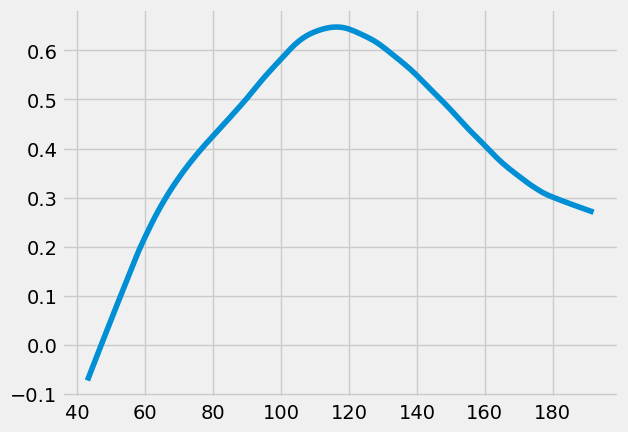

In [104]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
# generate the input and output sequences
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
print()
NDVI[30].plot()

datasetTrain = np.reshape(NDVI[30].data_matrix.flatten(),(NDVI[30].data_matrix.flatten().shape[0],1))
datasetTrain = datasetTrain.reshape(-1, 1)

n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []
for i in range(n_lookback, len(datasetTrain) - n_forecast + 1):
    X.append(datasetTrain[i - n_lookback: i])
    Y.append(datasetTrain[i: i + n_forecast])
X = np.array(X)
Y = np.array(Y)

# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback,1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(n_forecast))

regressor.compile(loss='mean_squared_error', optimizer='adam')
regressor.fit(X, Y, epochs=1000, batch_size=32)


In [105]:


dataset_total = np.reshape(NDVI[31].data_matrix.flatten(),(NDVI[31].data_matrix.flatten().shape[0],1))
inputs = dataset_total[-2*n_lookback:-n_lookback] # generare "l'ultima sequenza disponibile"
print(inputs.shape)
inputs = inputs.reshape(1, n_lookback, 1)
print(inputs.shape)
print(inputs)
#inputs  = sc.transform(inputs)
# Preparing X_test and predicting the prices

#X_test = []
#for i in range(Window,testLenght+Window):
#    X_test.append(inputs[i-Window:i,0])
#X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
#
#print(X_test.shape)

predicted_stock_price = regressor.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#print(predicted_stock_price)

(60, 1)
(1, 60, 1)
[[[0.37106869]
  [0.379846  ]
  [0.38833928]
  [0.39658673]
  [0.40463456]
  [0.41247502]
  [0.42008326]
  [0.42759768]
  [0.43512358]
  [0.44269578]
  [0.45032491]
  [0.45800594]
  [0.46569023]
  [0.47333802]
  [0.48108254]
  [0.48893306]
  [0.49682918]
  [0.50495141]
  [0.51335235]
  [0.52194441]
  [0.53059125]
  [0.53914274]
  [0.54741382]
  [0.55530391]
  [0.56302626]
  [0.57064571]
  [0.57814975]
  [0.58573877]
  [0.59343375]
  [0.60106629]
  [0.60842904]
  [0.61532973]
  [0.62155247]
  [0.62698484]
  [0.63175783]
  [0.63589165]
  [0.63933987]
  [0.6422929 ]
  [0.64489292]
  [0.64715092]
  [0.64906669]
  [0.6506309 ]
  [0.6517091 ]
  [0.65213931]
  [0.65201696]
  [0.6513086 ]
  [0.64982519]
  [0.6476626 ]
  [0.64500547]
  [0.64200707]
  [0.63883635]
  [0.6356295 ]
  [0.63234089]
  [0.62875864]
  [0.62489663]
  [0.62069146]
  [0.61593159]
  [0.61072588]
  [0.60525823]
  [0.59965674]]]
1/1 [==============================] - 1s 1s/step


C:\Users\Leo\AppData\Local\Temp\ipykernel_2204\3166317206.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


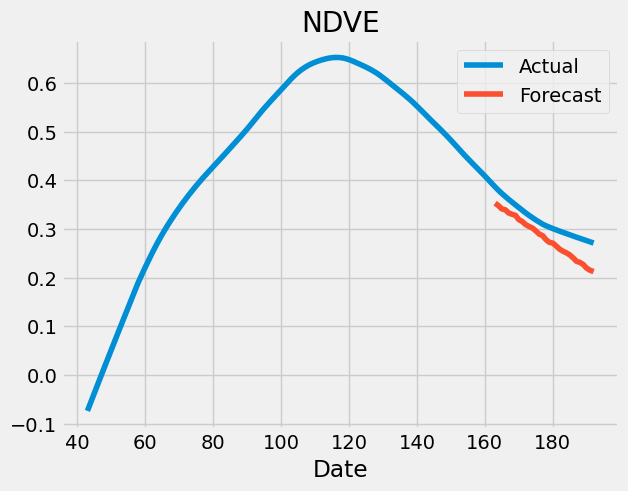

In [107]:
# organize the results in a data frame
Days = range(43,193)
df_past = pd.DataFrame(columns=['Date', 'Actual'])
df_past['Date'] = Days
df_past['Actual'] = dataset_total

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = Days[-n_forecast:]
df_future['Forecast'] = predicted_stock_price.flatten() #ha offset di 0.2 ma non si sa perche' :/ 

results = df_past.append(df_future).set_index('Date')
results.plot(title='NDVE')

In [15]:
# Evaluating our model
print(test_set.shape)
print(predicted_stock_price.shape)
return_rmse(test_set,predicted_stock_price)

(30, 1)
(30, 1)
The root mean squared error is 0.077805492893546.


# Andiamo a costruire il modello GRU

In [16]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


c:\Users\Leo\.conda\envs\Agrivision\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 6s 6s/step - loss: 0.6414
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.4704
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2478
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.0761
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0369
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1052
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 0.2428
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2878
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2149
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1172
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0598
Epoch 12/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0301
Epoch 13/50
1/1 [==============================] - 0s 24ms/step - loss: 0.

In [17]:
# Preparing X_test and predicting the prices
print(X_test.shape)
X_test = []
for i in range(Window,testLenght+Window):
    X_test.append(inputs[i-Window:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

(30, 10, 1)
1/1 [==============================] - 1s 1s/step


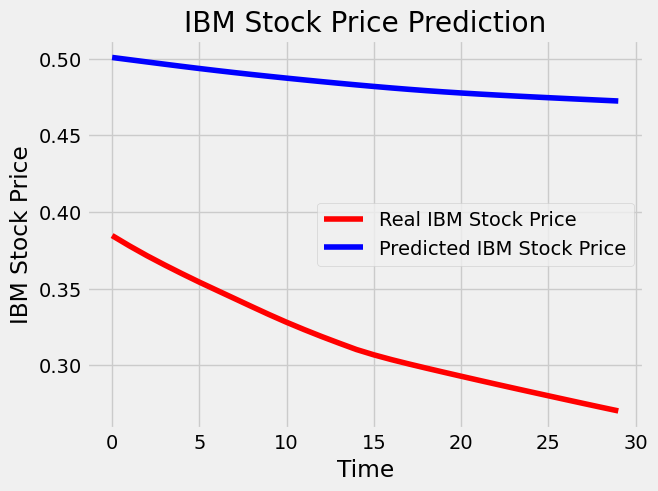

In [18]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [19]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 0.16943611539406891.
